# Определение стоимости автомобилей

**Задача**

>Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 
<br><br>
Заказчику важны:
<br> - качество предсказания;
<br> - скорость предсказания;
<br> - время обучения.

**Описание данных**

| columns | description |
| ------- |:---------- |
| DateCrawled | дата скачивания анкеты из базы
| VehicleType | тип автомобильного кузова
| RegistrationYear | год регистрации автомобиля
| Gearbox | тип коробки передач
| Power | мощность (л. с.)
| Model | модель автомобиля
| Kilometer | пробег (км)
| RegistrationMonth | месяц регистрации автомобиля
| FuelType | тип топлива
| Brand | марка автомобиля
| NotRepaired | была машина в ремонте или нет
| DateCreated | дата создания анкеты
| NumberOfPictures | количество фотографий автомобиля
| PostalCode | почтовый индекс владельца анкеты (пользователя)
| LastSeen | дата последней активности пользователя
| **price** | **цена (евро)**

## Подготовка данных

Импортируем необходимые библиотеки.

In [1]:
#%pip install catboost
#%pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import random
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

In [3]:
pd.options.display.max_rows = 100
sns.set_style('whitegrid', 
              {'ytick.left':True,
               'xtick.bottom':True,
               'xtick.color':(0.25, 0.25, 0.25), 
               'ytick.color':(0.25, 0.25, 0.25)})

Загрузим файл CSV и сохраним его в переменную *data*.

In [4]:
data = pd.read_csv('datasets/autos.csv')

Проверим правильность загрузки и общую информацию датасета.

In [5]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Создадим новый столбец с возрастом авто, который примем как разницу между годом публикации объявления и годом регистрации авто. Если значение возраста получится отрицательным, то заменим его нулем.

In [6]:
data['CarAges'] = data['DateCreated'].apply(lambda x: x[:4]).astype('int') - data['RegistrationYear']

In [7]:
data['CarAges'] = data['CarAges'].where(data['CarAges'] >= 0, 0)
data = data[data['CarAges'] < 107]

Удалим столбцы с данными, которые не несут информации об автомобиле и заведомо не влияют на цену.

In [8]:
data.drop(['DateCrawled',
           'RegistrationMonth',
           'DateCreated',
           'PostalCode',
           'LastSeen',
           'NumberOfPictures',
           'RegistrationYear'],
          axis=1, inplace=True)

In [9]:
data.isna().sum()

Price              0
VehicleType    37424
Gearbox        19776
Power              0
Model          19672
Kilometer          0
FuelType       32843
Brand              0
NotRepaired    71098
CarAges            0
dtype: int64

Имеютя пропуски в пяти столбцах. Удалим из выборки объекты, у которых имеются 3 и более пропусков в данных. Таким образом уменьшим количество строк с пропусками, остальные заполним некоторыми значениями.

In [10]:
data = data[data.isna().sum(axis=1) < 3]

Мощность авто более 1500 л.с. вероятне всего является некорректной информацией. Удалим объекты с значениями превышающими 1500 л.с.

In [11]:
print('Число авто, мощностью более 1500 л.с.:', data[data['Power'] > 1500].shape[0])

Число авто, мощностью более 1500 л.с.: 190


In [12]:
data = data[data['Power'] <= 1500]

Попробуем восстановить часть пропущенных данных. Заполним пропуски в столбцах *Gearbox* и *FuelType*, на основании данных по столбцу *VehicleType*. Создадим таблицу, в которой для каждого типа авто будет записана частота, с которой встречаются разные типы коробки передач (*Gearbox*) и типа топлива (*FuelType*).

In [13]:
vehicle_grouped = data.groupby('VehicleType')
vehicle_dict = {}

unique_gearbox = len(data['Gearbox'].unique()) - 1
vg_gearbox = vehicle_grouped['Gearbox'].value_counts(normalize=True)
for index in vg_gearbox.index[::unique_gearbox]:
    vehicle_type = index[0]
    vehicle_dict[vehicle_type] = {}
    vehicle_dict[vehicle_type]['Gearbox'] = [vg_gearbox[vehicle_type].index, vg_gearbox[vehicle_type].values]
    
unique_fuel = len(data['FuelType'].unique()) - 1
vg_fuel = vehicle_grouped['FuelType'].value_counts(normalize=True)
for index in vg_fuel.index[::unique_fuel]:
    vehicle_type = index[0]
    vehicle_dict[vehicle_type]['FuelType'] = [vg_fuel[vehicle_type].index, vg_fuel[vehicle_type].values]
    
# if vehicle type is missing, set 'manual' for gearbox and 'petrol' as fuel type
vehicle_dict['nan'] = {
    'Gearbox': [['manual'], [1]],
    'FuelType': [['petrol'], [1]]
}

Напишем функцию, которая на основе типа авто заполнит пропуски в столбцах *Gearbox* и *FuelType* значениями из таблицы *vehicle_dict*. Функция будет присваивать то, или иное значение с вероятностью, равной частоте появления признака в исходной выборке для данного типа авто.

In [14]:
def fill_by_prob(row, column):
    vehicle_type = str(row['VehicleType'])
    value = row[column]
    
    # If value is missing, choose randomly, according to the frequency of feature
    if type(value) == float:
        index, weights = vehicle_dict[vehicle_type][column]
        value = random.choices(index, weights=weights)[0]
        
    return value

In [15]:
data['Gearbox'] = data.apply(fill_by_prob, args=['Gearbox'], axis=1)
data['FuelType'] = data.apply(fill_by_prob, args=['FuelType'], axis=1)

Пропущенные значения в столбце *Model* заполним названием бренда авто (*Brand*). 

In [16]:
data.loc[data['Model'].isna(), 'Model'] = data['Brand']

Значения мощности авто, которые являются явно слишком низкими, заменим средним значением для данной модели. 

In [17]:
def model_power(row):
    model = row['Model']
    power = row['Power']
    if power > 10:
        return power
    return model_dict[model]

In [18]:
model_dict = {}
for model in data['Model'].unique():
    model_dict[model] = round(data[data['Model']==model]['Power'].mean())

In [19]:
data['Power'] = data[['Model', 'Power']].apply(model_power, axis=1)

Оставшиеся пропуски в данных заполним значением "unknown".

In [20]:
data.fillna('unknown', axis=1, inplace=True)

Целевой признак - цена авто (*Price*). Проверим распределение значений цены в выборке.

In [21]:
sns.__version__

'0.9.0'

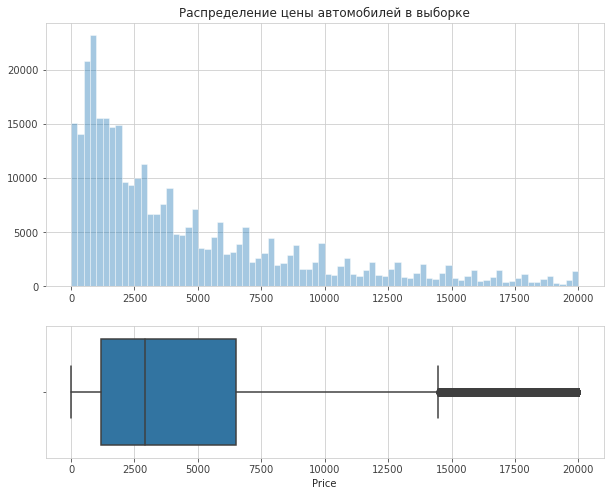

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})

ax[0].set_title('Распределение цены автомобилей в выборке')
sns.distplot(data['Price'], bins=80, kde=False, ax=ax[0])
ax[0].set_xlabel('')

sns.boxplot(x=data['Price'], ax=ax[1])
plt.show()

Распределение цены имеет вид похожий на логнормальное распределение. Можно заметить, что цена склонна принимать круглые значения кратные 1000.

### Вывод

Были загружены и исследованы исходные данные. Пропуски были заполнены разными методами, удалены явно неверные записи, удалены из выборки заведомо невлияющие на цену признаки. Изучили распределение цены авто в выборке. Данные подготовлены для дальнейшего анализа.

## Обучение моделей

Разделим выборку на обучающую и тестовую в соотношении 7:3. Выделим в каждой выборке целевой признак в отдельную переменную.

In [23]:
train, test = train_test_split(data, train_size=0.7, random_state=12345)

In [24]:
features = train.drop(['Price'], axis=1)
target = train['Price']

test_features = test.drop(['Price'], axis=1)
test_target = test['Price']

In [25]:
print('Train set:', features.shape, '\nTest set:', test_features.shape)

Train set: (235302, 9) 
Test set: (100844, 9)


Для оценки качества модели будем применять метрику RMSE.

In [26]:
def rmse(target, predictions):
    return round(mean_squared_error(test_target, predictions) ** 0.5, 2)

Создадим модель DummyRegressor. В дальнейшем будем сравнивать с ней результаты других моделей, чтобы убедиться в их эффективности.

In [27]:
# Train DummyRegressor
start = time.process_time()
dummy_model = DummyRegressor(strategy='median')
dummy_model.fit(features, target)
train_time = time.process_time() - start

# Dummy predict
start = time.process_time()
predictions = dummy_model.predict(test_features)
predict_time = time.process_time() - start

dummy_result = rmse(test_target, predictions)

rmse_metrics = pd.DataFrame({'rmse': dummy_result, 'train_time': train_time, 'predict_time': predict_time}, index=['DummyRegressor'])
rmse_metrics

,rmse,train_time,predict_time
DummyRegressor,4838.49,0.004289,0.0005


### Ridge Regression

Преобразуем данные в выборках. Используем LabelEncoding для категориальных переменных и стандартизуем данные с помощью StandardScaler.

In [28]:
features_scaled = features.copy()
test_features_scaled = test_features.copy()

category_columns = ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
encoder = LabelEncoder()

for column in category_columns:
    encoder.fit(data[column])
    features_scaled[column] = encoder.transform(features_scaled[column])
    test_features_scaled[column] = encoder.transform(test_features_scaled[column])

In [29]:
scaler = StandardScaler()
scaler.fit(features_scaled)
features_scaled[:] = scaler.transform(features_scaled)
test_features_scaled[:] = scaler.transform(test_features_scaled)

Создадим модель гребневой регрессии (*Ridge Regression*). Получим предсказания на тестовой выборке, отдельно вычислим время обучения и время предсказания модели. Запишем полученные величины в таблицу. 

In [30]:
# Ridge Regressor train
start = time.process_time()
ridge_model = Ridge()
ridge_model.fit(features_scaled, target)
train_time = time.process_time() - start

# Ridge Regressor predict
start = time.process_time()
predictions = ridge_model.predict(test_features_scaled)
predict_time = time.process_time() - start

ridge_result = rmse(test_target, predictions)

rmse_metrics.loc['Ridge'] = [ridge_result, train_time, predict_time]
rmse_metrics

,rmse,train_time,predict_time
DummyRegressor,4838.49,0.004289,0.00050
Ridge,3122.30,0.033478,0.01848


Ridge показывает значения метрики RMSE лучше медианной модели.

### RandomForest Regressor

Используем модель случайного леса (*Random Forest*). Подберем параметры для глубины деревьев и количества оценщиков.

In [31]:
def cv_result(grid):
    df = pd.DataFrame(grid.cv_results_).iloc[:, [0, 4, 5, 10]]
    df['mean_test_score'] = round(abs(df['mean_test_score']) ** 0.5, 2)
    return df.sort_values('mean_test_score')

In [32]:
params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30]
}
rf_model = RandomForestRegressor(random_state=12345, max_features='log2')
rf_grid = GridSearchCV(rf_model,
                       params,
                       cv=3, 
                       scoring='neg_mean_squared_error', 
                       n_jobs=-1, 
                       refit=False,
                       verbose=2)

rf_grid.fit(features_scaled, target)
cv_result(rf_grid)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.6min finished


,mean_fit_time,param_max_depth,param_n_estimators,mean_test_score
3,59.664702,20,200,1712.86
2,26.779555,20,100,1717.20
5,56.507032,30,200,1727.97
4,34.108356,30,100,1730.95
1,31.296857,10,200,1955.74
0,17.317153,10,100,1957.77


Лучшие показатели получились при глубине деревьев 20 и количестве оценщиков 200. Используем эти параметры, обучим модель и получим предсказания для тестовой выборки. Время выполнения операций и метрику RMSE запишем в таблицу.

In [33]:
rf_model.set_params(max_depth=20, n_estimators=200)

# RandomForest train
start = time.process_time()
rf_model.fit(features_scaled, target)
train_time = time.process_time() - start

# RandomForest predict
start = time.process_time()
predictions = rf_model.predict(test_features_scaled)
predict_time = time.process_time() - start

rmse_metrics.loc['RandomForest'] = [rmse(test_target, predictions), train_time, predict_time]
rmse_metrics

,rmse,train_time,predict_time
DummyRegressor,4838.49,0.004289,0.000500
Ridge,3122.30,0.033478,0.018480
RandomForest,1689.64,53.274468,7.289638


Модель случайного леса имеет большее время обучения и время предсказания, но качество модели лучше, чем у модели Ridge.

### CatBoostRegressor

Для моделей градиентного бустинга преобразуем категориальные признаки в обучающей и тестовой выборках в категориальный тип данных.

In [34]:
features[category_columns] = features[category_columns].astype('category')
test_features[category_columns] = test_features[category_columns].astype('category')

Подберем параметры обучения для модели CatBoost.

In [35]:
params = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [8, 12]
}
cat_model = CatBoostRegressor(n_estimators=200,
                              random_state=12345,
                              loss_function='RMSE',
                              cat_features=category_columns,
                              verbose=200)
cat_grid = GridSearchCV(cat_model,
                        params,
                        cv=3,
                        scoring='neg_mean_squared_error',
                        n_jobs=-1,
                        refit=False)

cat_grid.fit(features, target)
cv_result(cat_grid)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


,mean_fit_time,param_learning_rate,param_max_depth,mean_test_score
3,136.689457,0.2,12,1704.47
1,173.318464,0.1,12,1717.59
2,88.619615,0.2,8,1739.73
0,79.806830,0.1,8,1772.40


Лучшие показатели получились при глубине деревьев **12** и скорости обучения **0.2**. Используем эти параметры, обучим модель и получим предсказания для тестовой выборки. Время выполнения операций и метрику RMSE запишем в таблицу.

In [36]:
cat_model.set_params(learning_rate=0.2, max_depth=12, verbose=25)

# CatBoost train
start = time.process_time()
cat_model.fit(features, target)
train_time = time.process_time() - start

# CatBoost predict
start = time.process_time()
predictions = cat_model.predict(test_features)
predict_time = time.process_time() - start

rmse_metrics.loc['CatBoost'] = [rmse(test_target, predictions), train_time, predict_time]
rmse_metrics

0:	learn: 3891.0876912	total: 347ms	remaining: 1m 9s
25:	learn: 1753.9133866	total: 7.48s	remaining: 50s
50:	learn: 1658.5358809	total: 14.9s	remaining: 43.4s
75:	learn: 1591.2449557	total: 22.7s	remaining: 37s
100:	learn: 1550.4442498	total: 31.4s	remaining: 30.7s
125:	learn: 1517.9298809	total: 40.2s	remaining: 23.6s
150:	learn: 1489.8416730	total: 49.1s	remaining: 15.9s
175:	learn: 1466.0011349	total: 58.1s	remaining: 7.93s
199:	learn: 1445.7620878	total: 1m 6s	remaining: 0us


,rmse,train_time,predict_time
DummyRegressor,4838.49,0.004289,0.000500
Ridge,3122.30,0.033478,0.018480
RandomForest,1689.64,53.274468,7.289638
CatBoost,1696.79,252.701337,0.765034


Качество модели CatBoost соответствует качеству случайного леса. Время обучения CatBoost значительно больше, чем у других моделей, но время предсказания меньше, чем у случайного леса.

Проверим на сколько каждый признак влияет на цену авто, по результатам обучения модели CatBoost.

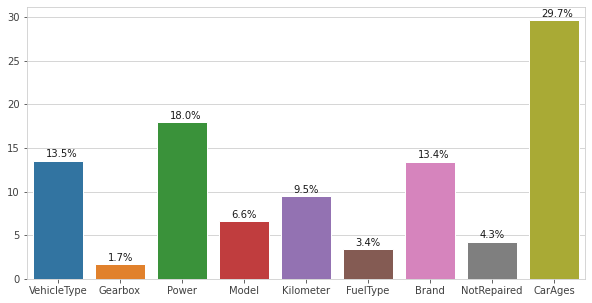

In [37]:
plt.figure(figsize=(10, 5))
chart = sns.barplot(x=features.columns, y=cat_model.feature_importances_.tolist())

for i in chart.patches:
    y_ofset = i.get_height() + 0.4
    chart.text(i.get_x() + 0.2, y_ofset, \
            str(round((i.get_height()), 1)) + '%', fontsize=10,
                color=(0, 0, 0, 0.9))

### LightGBM

Подберем параметры глубины деревьев и скорости обучения для модели LightGBM.

In [38]:
params = {"max_depth": [4, 6, 8],
          "learning_rate": [0.1, 0.2, 0.3]}

lgb_model = LGBMRegressor(n_estimators=200, random_state=12345)
lgb_grid = GridSearchCV(lgb_model, params, scoring='neg_mean_squared_error', cv=3)
lgb_grid.fit(features, target)
cv_result(lgb_grid)

,mean_fit_time,param_learning_rate,param_max_depth,mean_test_score
5,0.949362,0.2,8,1709.36
8,0.877811,0.3,8,1715.03
4,1.056719,0.2,6,1717.76
7,0.962603,0.3,6,1719.72
2,1.193611,0.1,8,1720.75
1,1.195046,0.1,6,1732.52
3,0.914638,0.2,4,1750.59
6,0.869080,0.3,4,1751.42
0,0.900255,0.1,4,1777.67


Лучшие показатели получены при глубине деревьев **8**, скорости обучения **0.2**. Используем эти параметры, обучим модель и получим предсказания для тестовой выборки. Время выполнения операций и метрику RMSE запишем в таблицу.

In [39]:
%%time
lgb_model.set_params(max_depth=8, learning_rate=0.2)

# LightGBM train
start = time.process_time()
lgb_model.fit(features, target, verbose=25)
train_time = time.process_time() - start

# LightGBM predict
start = time.process_time()
predictions = lgb_model.predict(test_features)
predict_time = time.process_time() - start

rmse_metrics.loc['LightGBM'] = [rmse(test_target, predictions), train_time, predict_time]
rmse_metrics

CPU times: user 6.45 s, sys: 48 ms, total: 6.5 s
Wall time: 1.76 s


,rmse,train_time,predict_time
DummyRegressor,4838.49,0.004289,0.000500
Ridge,3122.30,0.033478,0.018480
RandomForest,1689.64,53.274468,7.289638
CatBoost,1696.79,252.701337,0.765034
LightGBM,1712.02,4.954667,1.535137


Модель LightGBM имеет немного хуже значения RMSE, но малое время обучения и среднюю скорость предсказания. 

## Анализ моделей

Построим графики результатов обучения разных моделей и сравним показатели качества - метрика RMSE, время обучения модели и время предсказания.

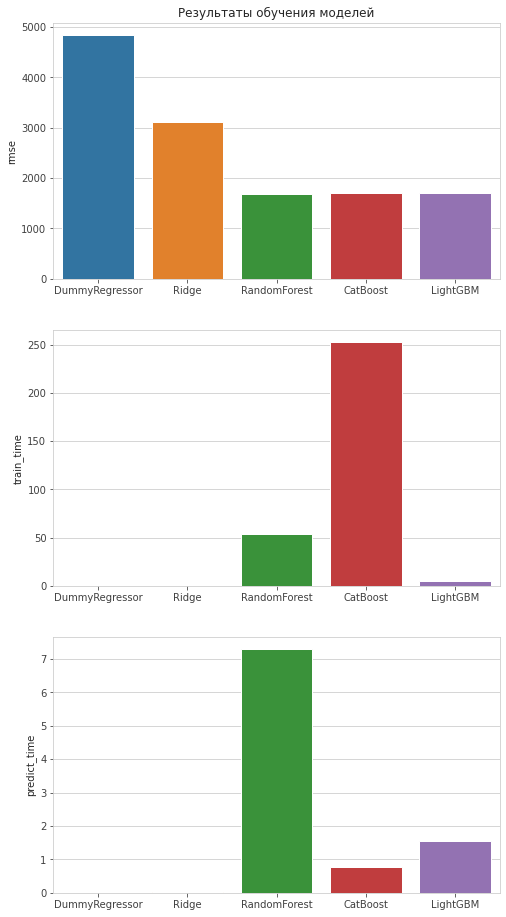

In [40]:
rmse_metrics.reset_index(inplace=True)
fig, ax = plt.subplots(3, 1, figsize=(8, 16))
sns.barplot(data=rmse_metrics, x='index', y='rmse', ax=ax[0])
ax[0].set_title('Результаты обучения моделей')
ax[0].set_xlabel('')
sns.barplot(data=rmse_metrics, x='index', y='train_time', ax=ax[1])
ax[1].set_xlabel('')
sns.barplot(data=rmse_metrics, x='index', y='predict_time', ax=ax[2])
ax[2].set_xlabel('')
plt.show()

Проанализируем каждую модель, определим их преимущества и недостатки.

Все три ансамблевые модели (RandomForest, CatBoost, LightGBM) имеют схожее качество предсказания. Однако по показателям времени выполнения в обоих метриках модель LightGBM превосходит RandomForest. В дальнейшем будем рассматривать только три модели Ridge, CatBoost и LightGBM.

<table>
    <tr>
        <td width=150>Модель<hr></td>
        <td width=300>Преимущества<hr></td>
        <td width=300>Недостатки<hr></td>
    </tr>
    <tr>
        <td height=50><b>Ridge</b></td>
        <td>1. Малое время предсказания<br>2. Малое время обучения</td>
        <td>Низкое качество предсказания</td>
    </tr>
    <tr>
        <td height=50><b>CatBoost</b></td>
        <td>1. Высокое качество предсказания<br>2. Малое время предсказания</td>
        <td>Большое время обучения</td>
    </tr>
    <tr>
        <td height=50><b>LightGBM</b></td>
        <td>1. Высокое качество предсказания<br>2. Малое время обучения</td>
        <td>Большое время предсказания</td>
    </tr>
</table>

## Вывод

В ходе работы были созданы предсказательные модели, использующие различные алгоритмы обучения. В ходе обучения и предсказания, были сделаны замеры времения исполнения. Предсказания были сделаны на выделенной из исходной таблице тестовой выборке. По результатам анализа результатов можно сделать следующие выводы:
- Из трех алгоритмов, которые рассматривали в анализе, каждая имеет свои недостатки и преимущества, отличные друг от друга;
- Модель Ridge отличается высокой скоростью обучения и предсказания, но качество предсказаний примерну вдвое хуже остальных;
- Модель CatBoost имеет высокое качество и корость предсказания, но время обучения модели чрезвычайно большое;
- Модель LightGBM аналогично CatBoost имеет высокое качество, время обучения занимает доли секунды, время предсказания самое высокое из всех моделей.

В условиях задачи было сказано, что для заказчика важными параметрами являются: качество предсказания, время обучения и скорость предсказания. Исходя из результатов анализа однозначно выбрать одну модель нельзя. Выбор будет зависеть от того, какой параметр имеет решающую роль для заказчика, а также не превышает ли какой либо параметр из предложенных моделей критические значения. 